### Descriptive model

In [1]:
import numpy as np
import pandas as pd
import shap

from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
# import colors
from matplotlib.colors import LinearSegmentedColormap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as trn
import torchvision.models as models
import torch.utils.data as data

In [2]:
# print the JS visualization code to the notebook
shap.initjs()

In [3]:
class singleModel(nn.Module):
    def __init__(self, in_dim, num_classes):
        super(singleModel, self).__init__()
        # ann branch functions
        self.fc1 = nn.Linear(in_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)
        
    def forward(self, data):       
        # ann branch
        x = F.relu(self.fc1(data))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return x

In [4]:
# create model and load weight
model = singleModel(348, 7)
model = torch.nn.DataParallel(model).cuda()
checkpoint = torch.load('/media/data_16T/maoransu/projects/building_material/output/model_simple/model_best.pth.tar')
start_epoch = checkpoint['epoch']
best_acc1 = checkpoint['best_acc1']


model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [5]:
# set model to eval mode
model.eval()

DataParallel(
  (module): singleModel(
    (fc1): Linear(in_features=348, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=7, bias=True)
  )
)

In [6]:
# load data
data = pd.read_pickle("/media/data_16T/maoransu/projects/building_material/data/training/single_test.p")
X = data.drop(columns=['label'])
y = data['label']

In [7]:
def f(X):
    return model(torch.tensor(X, dtype=torch.float,requires_grad=False).cuda()).argmax(axis=1).cpu().detach().numpy()

In [9]:
explainer = shap.KernelExplainer(f, X.iloc[:50,:].values)

In [10]:
shap_values50 = explainer.shap_values(X.iloc[25000:,:])

  0%|          | 0/1546 [00:00<?, ?it/s]

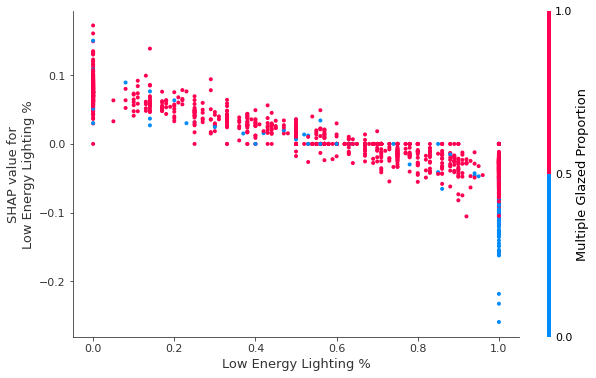

In [28]:
fig, ax = plt.subplots(figsize=(10,6))

shap.dependence_plot(2, shap_values50, X.iloc[25000:,:], show=False, ax=ax)

plt.show()

In [29]:
fig.savefig("/media/data_16T/maoransu/projects/building_material/paper/SHAP_lowEnergyLighting.png",bbox_inches='tight', dpi=300)

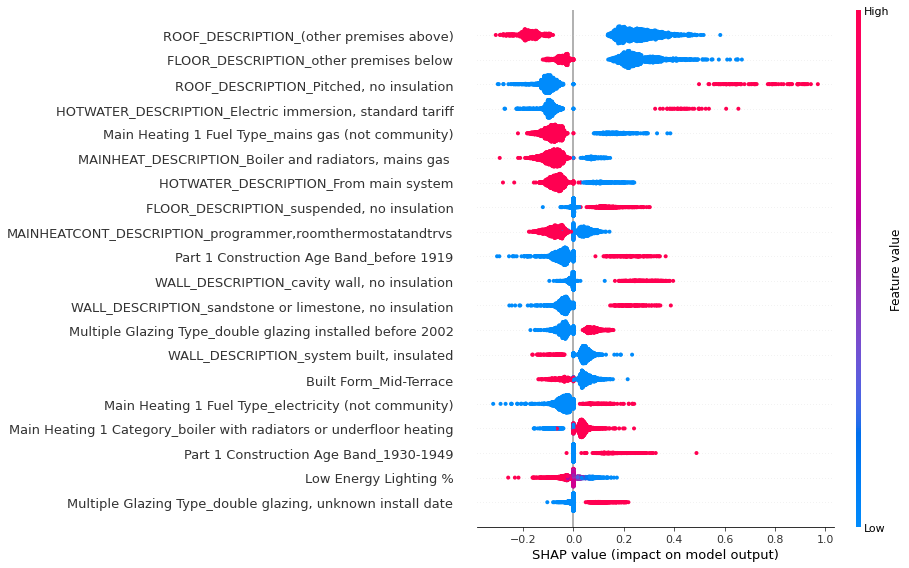

In [32]:

shap.summary_plot(shap_values50, X.iloc[25000:,:], show=False)

plt.savefig('importance_scatter_xgb.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [25]:
plt.savefig("/media/data_16T/maoransu/projects/building_material/paper/summary_plot.pdf")

<Figure size 432x288 with 0 Axes>

### fusion model

In [20]:
class multiBranchModel(nn.Module):
    def __init__(self, in_dim, out_dim, num_classes):
        super(multiBranchModel, self).__init__()
        # densenet branch functions
        self.cnn = models.__dict__['densenet121'](pretrained=True)._modules.get('features')
        # ann branch functions
        self.neural1 = nn.Linear(in_dim, 1024)
        self.neural2 = nn.Linear(1024, 512)
        self.neural3 = nn.Linear(512, 256)
        self.neural4 = nn.Linear(256, out_dim)
        
        self.fc1 = nn.Linear(1024 + out_dim, 1024)
        self.fc2 = nn.Linear(1024, 256)
        # self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)
        
    def forward(self, image, data):
        # densenet branch
        x1 = self.cnn(image)
        x1 = F.relu(x1, inplace=True)
        x1 = F.adaptive_avg_pool2d(x1, (1,1))
        x1 = torch.flatten(x1, 1)
        
        # ann branch
        x2 = F.relu(self.neural1(data))
        x2 = F.relu(self.neural2(x2))
        x2 = F.relu(self.neural3(x2))
        x2 = F.relu(self.neural4(x2))
        
        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
class Dataset(data.Dataset):
    def __init__(self, imgList, attrList, labelList, transform = None):
     
        self.imgList = imgList
        self.attrList = attrList
        self.labelList = labelList
        self.transform = transform
            
    def __getitem__(self, index):

        img_path = self.imgList[index]
        image = Image.open(img_path).convert('RGB')
        attrs = self.attrList[index]
        label = self.labelList[index]
    
        if self.transform:
            image = self.transform(image)
        
        attrs = torch.FloatTensor(attrs)
        sample = (img_path,image,attrs,label)
        
        return sample
        
    def __len__(self):
        # You should change 0 to the total size of your dataset.
        return len(self.imgList) 

In [21]:
# create model and load weight
model = multiBranchModel(348, 256, 7)
model = torch.nn.DataParallel(model).cuda()
checkpoint = torch.load('/media/data_16T/maoransu/projects/building_material/output/model_fusion_mix_v1/model_best.pth.tar')
start_epoch = checkpoint['epoch']
best_acc1 = checkpoint['best_acc1']

model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [22]:
model.eval()

DataParallel(
  (module): multiBranchModel(
    (cnn): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momen

In [23]:
#define transformer
tf = trn.Compose([
        trn.Resize([224,224]),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [24]:
# load data
dataDF = pd.read_pickle("/media/data_16T/maoransu/projects/building_material/data/training/fusion_train_mix_v1_gap2.p")

valDF = dataDF[dataDF.split == 'val']

valDataset = Dataset(valDF.path.tolist(), valDF['attrs'].tolist(), np.array(valDF.label), tf)

val_loader = torch.utils.data.DataLoader(
                valDataset,
                batch_size= 1, 
                shuffle=False,
                num_workers= 4, 
                pin_memory=True)

In [25]:
paths, imgs, attrs, targets = [], [], [], []

for batch_idx, (img_path, image, attr, target) in enumerate(val_loader):
#     if batch_idx in idxes:
    paths.append(img_path)
    imgs.append(image)
    attrs.append(attr)
    targets.append(target)
    if batch_idx > 100:
        break

In [26]:
# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(model, [imgs[0].cuda(), attrs[0].cuda()])

# # we explain the model's predictions on the first three samples of the test set
# shap_values = explainer.shap_values([imgs[3].cuda(), attrs[3].cuda()])

In [27]:
# we explain the model's predictions on the first three samples of the test set
shaps = []
for i in tqdm(range(len(imgs))):
    shap_values = explainer.shap_values([imgs[i].cuda(), attrs[i].cuda()])
    shaps.append(shap_values)
#     shap_values = explainer.shap_values([imgs[3].cuda(), attrs[3].cuda()])

100%|██████████| 102/102 [16:00<00:00,  9.42s/it]


In [14]:
# color for plot
colors = []
for l in np.linspace(1, 0, 100):
    colors.append((30./255, 136./255, 229./255,l))
for l in np.linspace(0, 1, 100):
    colors.append((255./255, 13./255, 87./255,l))
red_transparent_blue = LinearSegmentedColormap.from_list("red_transparent_blue", colors)

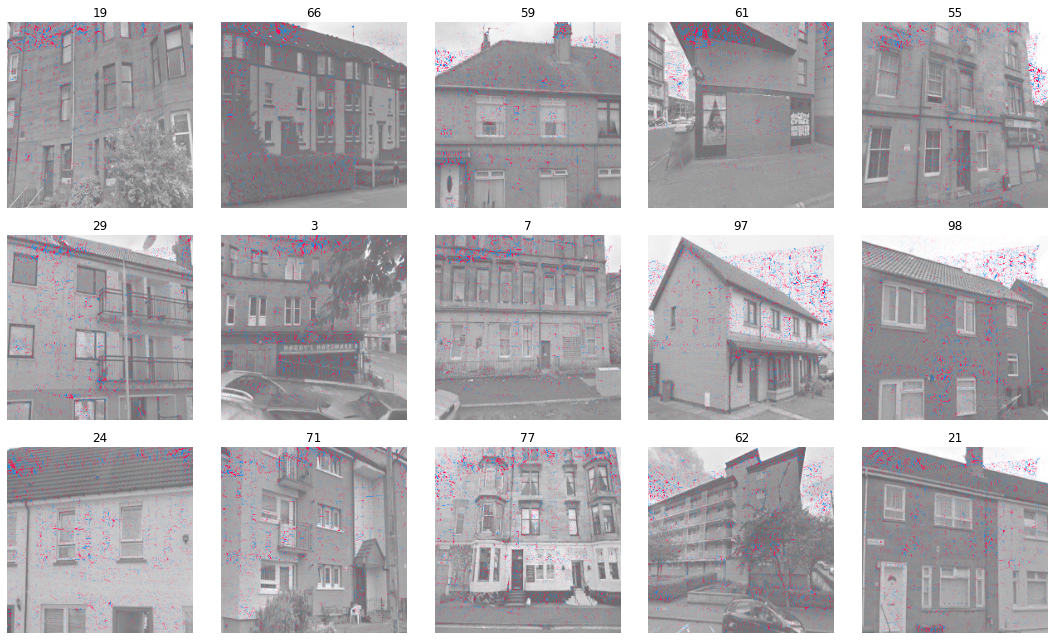

In [37]:
# plot results from the shaps
idxes = np.random.choice(np.arange(100), 25, replace=False)

# idxes= [37, 23, 24, 64, 60,
#         38, 19, 35, 15, 7, 
#         56, 31, 77, 54, 86
#        ]


fig, ax = plt.subplots(3,5, figsize=(15,9))

for i in range(3):
    for j in range(5):
        idx = idxes[j*3+i]
#         idx = j*3+i
        # get base image
        img = cv2.imread(paths[idx][0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224), cv2.INTER_NEAREST)
        # get shap value map
        hmap = shaps[idx][targets[idx]][0].reshape(3,224,224).sum(axis=0)
        max_val = np.nanpercentile(hmap, 99.9)
        # plot results
        ax[i][j].imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cmap='gray', alpha=0.6)
        ax[i][j].imshow(hmap, cmap=red_transparent_blue, vmin=-max_val, vmax=max_val)
        
        ax[i][j].axis('off')
        ax[i][j].title.set_text(idx)

# fig.suptitle('SHAP Value')
fig.tight_layout()
plt.show()

In [42]:
fig.savefig("/media/data_16T/maoransu/projects/building_material/paper/SHAP_base.png",bbox_inches='tight', dpi=300)